## Imports

In [1]:
import requests
import xyzservices.providers as xyz

from utils import *

## US states & counties
Download the boundary shapefiles of the lower 48 US states and counties using the TIGER/Line API.

In [5]:
df = gpd.read_parquet('_access/zones/us/county_2020.parquet').disp()

3,234 rows x 5 cols; Memory: 0.4 MiB; <Geographic 2D CRS: EPSG:4326>


,geoid,name,aland,awater,geometry
,<object>,<object>,<int64>,<int64>,<geometry>
0,01001,Autauga,1539634184,25674812,"POLYGON ((-86.903096 32.540626, -86.903115 32...."


In [2]:
year = 2020

In [3]:
# url = 'https://www2.census.gov/geo/tiger/TIGER{0}/STATE/tl_{0}_us_state.zip'.format(year)
# states = (gpd.read_file(url).rename(columns=str.lower).to_crs(CRS_DEG)
#           [['geoid', 'name', 'region', 'division', 'geometry']])
# url = 'https://raw.githubusercontent.com/jasonong/List-of-US-States/refs/heads/master/states.csv'
# state_abbr = pd.read_csv(url).rename(columns=D(State='name', Abbreviation='code'))
# states = states.merge(state_abbr, on='name')
# # rename US Census regions and divisions
# states.region = states.region.astype(int).map({
#     1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'})
# states.division = states.division.astype(int).map({
#     1: '1. New England', 2: '2. Middle Atlantic',
#     3: '3. East North Central', 4: '4. West North Central',
#     5: '5. South Atlantic', 6: '6. East South Central',
#     7: '7. West South Central', 8: '8. Mountain', 9: '9. Pacific'
# })
# # remove Alaska and Hawaii
# states = (states[~states.name.isin(['Alaska', 'Hawaii'])]
#           .sort_values('geoid').reset_index(drop=1)
#           ['geoid code name region division geometry'.split()]).disp()
# states.to_parquet('data/states.parquet') # 3s
states = gpd.read_parquet('data/states.parquet').disp()

49 rows x 6 cols; Memory: 0.0 MiB; <Geographic 2D CRS: EPSG:4326>


,geoid,code,name,region,division,geometry
,<object>,<object>,<object>,<object>,<object>,<geometry>
0,01,AL,Alabama,South,6. East South Central,"POLYGON ((-88.139988 34.581703, -88.139969 34...."


In [4]:
# url = 'https://www2.census.gov/geo/tiger/TIGER{0}/COUNTY/tl_{0}_us_county.zip'.format(year)
# counties = (gpd.read_file(url).rename(columns=str.lower)
#             .rename(columns=D(name='county')).to_crs(CRS_DEG)
#             ['geoid county aland awater geometry'.split()])
# for x in ['aland', 'awater']: # convert area from sq.m. to sq.mi.
#     counties[x] = (counties[x] * SQM2SQMI).astype(F32)
# counties.to_parquet('data/counties.parquet') # 19s
counties = gpd.read_parquet('data/counties.parquet').disp()

3,234 rows x 5 cols; Memory: 0.4 MiB; <Geographic 2D CRS: EPSG:4326>


,geoid,county,aland,awater,geometry
,<object>,<object>,<float32>,<float32>,<geometry>
0,31039,Cuming,570.519409,4.127492,"POLYGON ((-97.019516 42.004097, -97.019519 42...."


## Population
Download the population and labor force size of each census block group from the American Community Survey dataset and additionally aggregate to the tract and county levels.

In [5]:
# popu_cols = D(B01001_001E='popu', B23025_002E='labor')
# popu = []
# for state in tqdm(states.geoid): # for each state
#     url = (f'https://api.census.gov/data/{year}/acs/acs5?' +
#            'get=' + ','.join(popu_cols) + '&for=block+group:*' +
#            f'&in=state:{state}+county:*+tract:*')
#     data = requests.get(url).json()
#     df = Pdf(data[1:], columns=data[0])
#     df.insert(0, 'geoid', df.pop('state') + df.pop('county') + 
#               df.pop('tract') + df.pop('block group'))
#     df = df.rename(columns=popu_cols).astype(D(popu=I32, labor=I32))
#     popu.append(df.assign(level='BG'))
#     for level, nchar in [('Tract', 11), ('County', 5)]:
#         df2 = df.assign(geoid=df.geoid.str[:nchar])
#         df2 = df2.groupby('geoid')[['popu', 'labor']].sum()
#         popu.append(df2.reset_index().assign(level=level))
# popu = (pd.concat(popu).reset_index(drop=1).astype(D(level=CAT))
#         [['geoid', 'level', 'popu', 'labor']]).disp()
# popu.to_parquet('data/population.parquet') # 1m38s
popu = pd.read_parquet('data/population.parquet').disp()

327,337 rows x 4 cols; Memory: 21.8 MiB


,geoid,level,popu,labor
,<object>,<category>,<int32>,<int32>
0,010610503006,BG,758,297


## Urban areas
Download the constituent census blocks of urban areas as defined by the Census Bureau. Then, identify the corresponding block groups and tracts which contain at least one block in each urban area.

In [6]:
# url = f'https://www2.census.gov/geo/docs/reference/ua/{year}_UA_BLOCKS.txt'
# cols = {'GEOID': 'geoid', f'{year}_UA_NAME': 'name', f'{year}_UACE': 'code'}
# df = pd.read_csv(url, sep='|', encoding_errors='replace', usecols=list(cols))
# df.rename(columns=cols, inplace=True)
# df.code = df.code.astype(str).str.zfill(5)
# df.geoid = df.geoid.astype(str).str.zfill(15)
# urba = []
# for level, nchar in [('County', 5), ('Tract', 11), ('BG', 12)]:
#     df2 = df.assign(geoid=df.geoid.str[:nchar])
#     df2 = df2.groupby(['code', 'name', 'geoid']).size()
#     df2 = df2.rename('n').reset_index().sort_values('n', ascending=0)
#     df2 = df2.drop_duplicates('geoid').sort_values('geoid')
#     urba.append(df2.assign(level=level))
# urba = pd.concat(urba).reset_index(drop=1)
# # urba['city'] = [x.split(',')[0].split('-')[0].split('/')[0] for x in urba.name]
# urba = urba[['code', 'name', 'level', 'geoid']].astype(
#     {x: CAT for x in ['level', 'name', 'code']})
# urba.to_parquet('data/urban_zones.parquet') # 18s
urba = pd.read_parquet('data/urban_zones.parquet').disp()

275,549 rows x 4 cols; Memory: 17.7 MiB


,code,name,level,geoid
,<category>,<category>,<category>,<object>
0,58600,"Montgomery, AL",County,01001


## 50 largest cities
Select the 50 most populous urban areas using the tract-level population.

In [7]:
def get_largest_cities(top, urba=urba, popu=popu):
    urba = urba.rename(columns=D(name='urba', code='ua_code'))
    df = urba.merge(popu[['geoid', 'popu']])
    df = df.groupby('urba', observed=False)['popu'].sum()
    df = df.sort_values(ascending=0).head(top).reset_index()
    df['city'] = [x.split(',')[0].split('-')[0].split('/')[0] for x in df.urba]
    print(Arr(df.city))
    df = urba[['geoid', 'level', 'ua_code', 'urba']].merge(df[['urba', 'city']])
    df = df.astype(D(level=str, urba=str, city=str))
    return df

top50 = get_largest_cities(50).disp()

['New York' 'Los Angeles' 'Chicago' 'Miami' 'Houston' 'Philadelphia'
 'Dallas' 'Washington' 'Atlanta' 'Boston' 'Phoenix' 'Detroit' 'Seattle'
 'San Francisco' 'San Diego' 'Riverside' 'Minneapolis' 'Tampa' 'Denver'
 'St. Louis' 'Baltimore' 'Portland' 'Las Vegas' 'San Antonio' 'Sacramento'
 'Austin' 'Pittsburgh' 'San Jose' 'Orlando' 'Cincinnati' 'Kansas City'
 'Indianapolis' 'Cleveland' 'Columbus' 'Virginia Beach' 'Charlotte'
 'Providence' 'Milwaukee' 'Jacksonville' 'Nashville' 'Salt Lake City'
 'Raleigh' 'Richmond' 'Memphis' 'Hartford' 'Buffalo' 'Louisville'
 'Oklahoma City' 'Tucson' 'Bridgeport']
144,156 rows x 5 cols; Memory: 33.8 MiB


,geoid,level,ua_code,urba,city
,<object>,<object>,<category>,<object>,<object>
0,04013,County,69184,"Phoenix--Mesa--Scottsdale, AZ",Phoenix


## Zones
Download the shapefile of the block groups and tracts which lie in the largest urban areas. Remove the zones with no land area for better plotting.

In [8]:
# uri = f'https://www2.census.gov/geo/tiger/TIGER{year}'
# cols = 'geoid level county ua_code city aland awater popu labor geometry'.split()
# zones = (counties.merge(top50, on='geoid')
#          .merge(popu.drop(columns='level'), on='geoid')[cols])
# # for each state which includes at least one major urban area
# for state in tqdm(set(top50.geoid.str[:2])):
#     for level in ['bg', 'tract']:
#         df = gpd.read_file('{}/{}/tl_{}_{}_{}.zip'.format(
#             uri, level.upper(), year, state, level))
#         df = df[df.ALAND > 0] # remove water-only zones
#         df = df.to_crs(CRS_DEG).rename(columns=str.lower)
#         for x in ['aland', 'awater']: # convert area from sq.m. to sq.mi.
#             df[x] = (df[x] * SQM2SQMI).astype(F32)
#         df = df.merge(top50, on='geoid')
#         df = df.merge(popu.drop(columns='level'), on='geoid')
#         df['county_id'] = df.geoid.str[:5]
#         df = df.merge(counties.rename(columns=D(geoid='county_id'))
#                       [['county_id', 'county']], on='county_id')
#         zones = pd.concat([zones, df[cols]], ignore_index=True)
# zones = zones.reset_index(drop=1).astype(D(
#     level=CAT, county=CAT, ua_code=CAT, city=CAT)).disp()
# zones.to_parquet('data/zones.parquet') # 5m37s
zones = gpd.read_parquet('data/zones.parquet').disp()

143,971 rows x 10 cols; Memory: 12.7 MiB; <Geographic 2D CRS: EPSG:4326>


,geoid,level,county,ua_code,city,aland,awater,popu,labor,geometry
,<object>,<category>,<category>,<category>,<category>,<float32>,<float32>,<int32>,<int32>,<geometry>
0,42007,County,Beaver,69697,Pittsburgh,434.692993,9.329071,164781,84153,"POLYGON ((-80.518963 40.733741, -80.518965 40...."


## Zone centroids
Coordinates of zone centroids to be used by the OSRM routing engine in `get_ttm.py` (via `osrm.sh`).

In [9]:
# pts = (zones.set_index(['geoid', 'level', 'city']).to_crs(CRS_M)
#        .centroid.to_crs(CRS_DEG).get_coordinates().reset_index()
#        .astype(D(level=str, city=str, x=F32, y=F32)))
# pts.city = [x.lower().replace(' ', '-').replace('.', '') for x in pts.city]
# pts.level = pts.level.str.lower()
# pts.to_parquet('data/centroids.parquet') # 6s
pts = pd.read_parquet('data/centroids.parquet').disp()

143,971 rows x 5 cols; Memory: 24.4 MiB


,geoid,level,city,x,y
,<object>,<object>,<object>,<float32>,<float32>
0,42007,county,pittsburgh,-80.349266,40.682495


## City to region
Associate each city with a US Census region and find its bounding box using its block group (BG) geometry. This is to be used by `extract_osm.sh` to prepare the OSM extracts of the urban areas using the extracts of the US Census regions. For cities spanning multiple regions, select the region with the most BGs.

In [10]:
bounds = (zones.set_index('city').bounds
          .groupby('city', observed=1).agg(D(
              minx='min', miny='min', maxx='max', maxy='max'))
          .apply(lambda x: np.round(x, 6)))
city2rgn = (filt(zones, level='BG')
            .assign(geoid=lambda df: df.geoid.str[:2])
            .groupby(['geoid', 'city'], observed=1)
            .size().rename('nBG').sort_values(ascending=0)
            .reset_index().drop_duplicates(subset='city')
            .merge(states, on='geoid')[['city', 'region']]
            .merge(bounds, on='city'))
for col in ['city', 'region']:
    city2rgn[col] = [x.lower().replace(' ', '-').replace('.', '')
                     for x in city2rgn[col]]
city2rgn.disp(None).to_csv('data/city_region.csv', index=False)

50 rows x 6 cols; Memory: 0.0 MiB


,city,region,minx,miny,maxx,maxy
,<object>,<object>,<float64>,<float64>,<float64>,<float64>
0,new-york,northeast,-74.982642,39.475198,-71.777491,41.527194
1,los-angeles,west,-118.951721,32.75004,-117.412987,34.823302
2,chicago,midwest,-88.707421,41.162186,-86.929353,42.495637
3,miami,south,-80.886053,25.13742,-79.974306,27.044106
4,houston,south,-96.088912,28.764837,-94.353383,30.271502
5,dallas,south,-97.770719,32.052087,-96.295057,33.405504
6,atlanta,south,-85.05031,33.191043,-83.674644,34.41259
7,boston,northeast,-71.898773,41.565851,-70.322522,42.967195
8,detroit,midwest,-83.70194,41.98833,-82.509937,42.972714


## Fig: City map

In [10]:
top_cities = (filt(zones, level='Tract')[['city', 'popu', 'geometry']]
              .dissolve('city', aggfunc='sum').to_crs(CRS_M)
              .assign(rank_=lambda df: df.popu.rank(ascending=0))
              .astype(D(rank_=I16)).reset_index()).disp() # 25s

50 rows x 4 cols; Memory: 0.0 MiB; <Projected CRS: EPSG:3857>


,city,geometry,popu,rank_
,<category>,<geometry>,<int32>,<int16>
0,Atlanta,"POLYGON ((-9456011.658897 3929034.468802, -945...",5084598,9


In [11]:
xyz.MapBox['accessToken'] = 'pk.eyJ1IjoiZW1waGFzZW50IiwiYSI6ImNtMGgyN3dqcTA2eHYyanBzeWUxZWc4YnYifQ.f6gyGE1jH2vijK9tHPVQMQ'

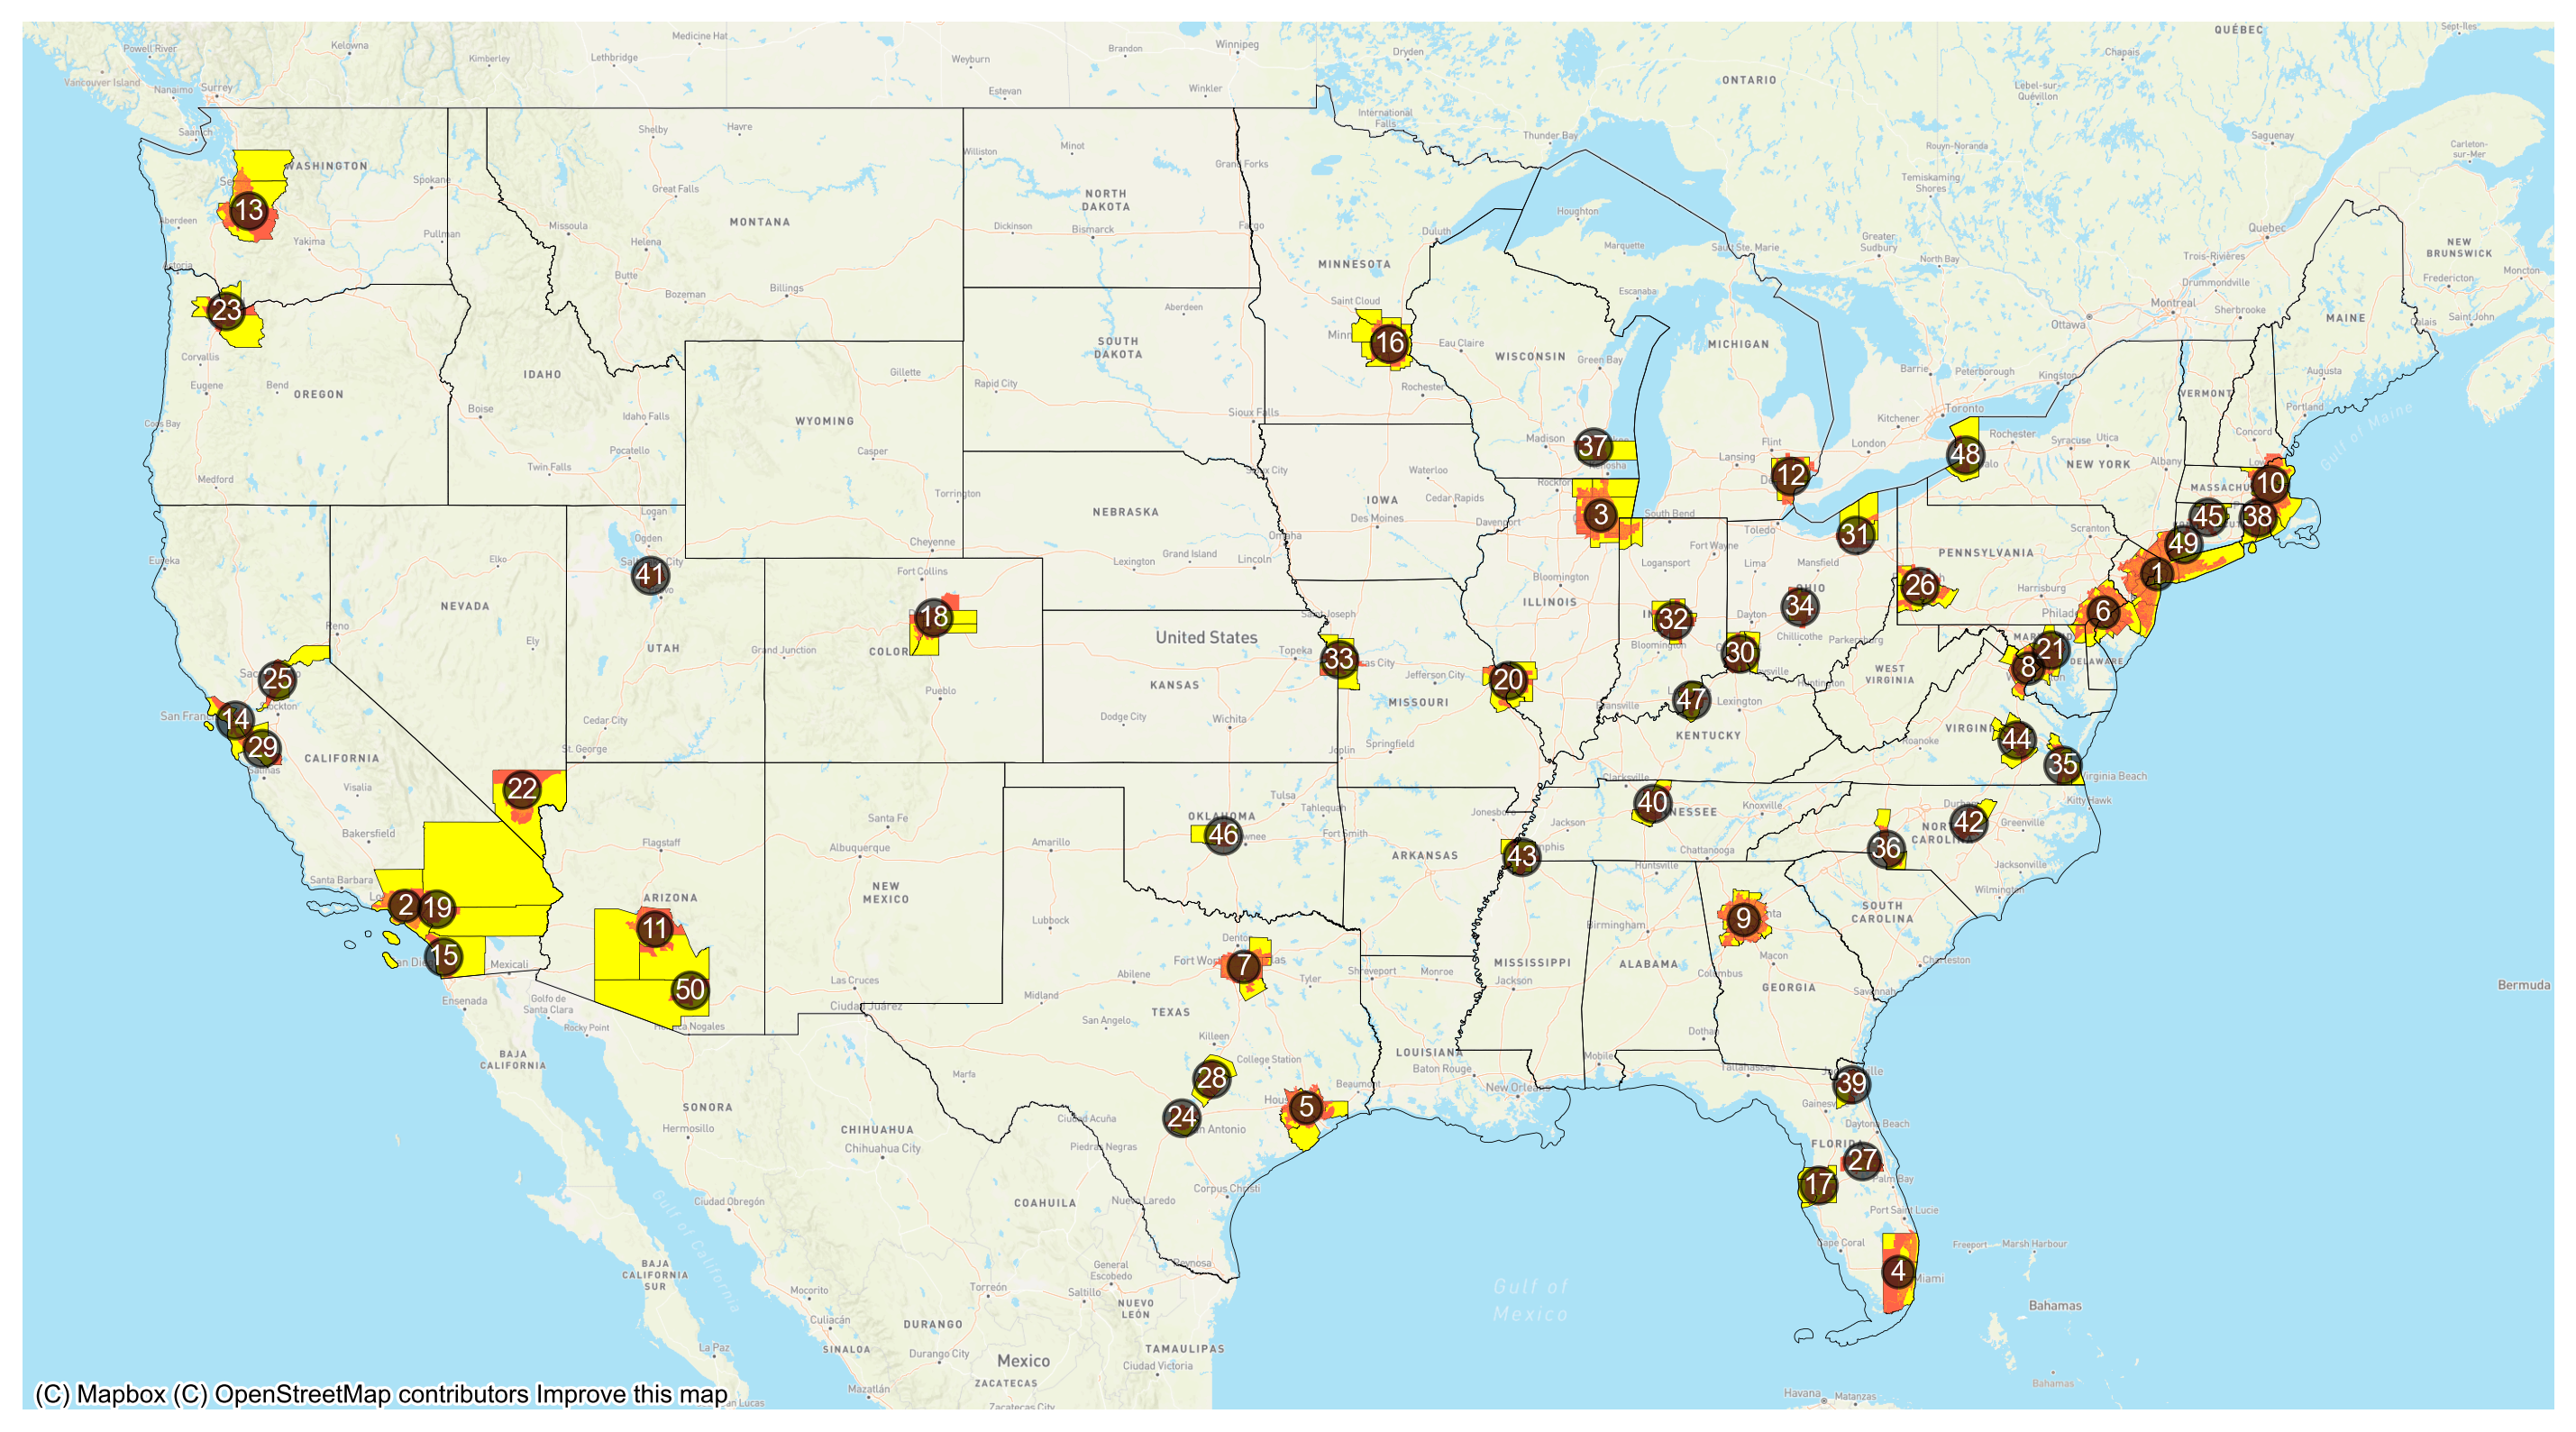

In [12]:
ax = plot(size=(16, 8), dpi=250, axoff=1)
df = filt(zones, level='County').to_crs(CRS_M)
df.plot(ax=ax, fc='yellow', ec='k', lw=0.2)
df = filt(zones, level='Tract').to_crs(CRS_M)
df.plot(ax=ax, color='tomato', alpha=1)
states.to_crs(CRS_M).plot(ax=ax, fc='none', ec='k', lw=0.25)
ctx.add_basemap(ax=ax, crs=CRS_M, source=ctx.providers.MapBox, alpha=0.6)
for _, r in top_cities.iterrows():
    ax.text(*r.geometry.centroid.coords[0], str(r.rank_),
            ha='center', va='center', fontsize=9, color='w',
            bbox=D(boxstyle='circle', pad=0.1, fc='k', alpha=0.6))
plt.savefig('fig/study_cities_map.png', dpi=300) # 23s